# Keras Segmentation Models | Nazih Kalo
In this kernel, we learn how to install and use pretrained Keras segmentation models from GitHub [here][1] with docs [here][2]. I I also add some additional EDA.

In the end I will show some more training examples, result of the UNET predictions and analyze the UNETs error and suggest future improvements.

[1]:https://github.com/qubvel/segmentation_models
[2]:https://segmentation-models.readthedocs.io/en/latest/tutorial.html

In [ ]:
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt, time
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

path = '../input/'
df = pd.read_csv(path + 'train.csv')

In [ ]:
train = pd.DataFrame(columns=['ImageId_ClassId', 'EncodedPixels'])
from tqdm import tqdm_notebook

for img_id, img_df in tqdm_notebook(df.groupby('ImageId')):
    for i in range(1, 5):
        avail_classes = list(img_df.ClassId)

        row = dict()
        row['ImageId_ClassId'] = img_id + '_' + str(i)

        if i in avail_classes:
            row['EncodedPixels'] = img_df.loc[img_df.ClassId == i].EncodedPixels.iloc[0]
        else:
            row['EncodedPixels'] = np.nan
        
        train = train.append(row, ignore_index=True)

In [ ]:
train.head()

# Data Generator
- Let's restructure the train.csv dataframe and build a data generator. 

- The input to our neural network will be `X_train` = images and target is `y_train` = masks. 

- We will resize all images by a factor of 0.5 for efficiency ==> Convert 256x1600 RGB to 128x800 RGB).

In [ ]:
# RESTRUCTURE TRAIN DATAFRAME
train['ImageId'] = train['ImageId_ClassId'].map(lambda x: x.split('.')[0]+'.jpg')
train2 = pd.DataFrame({'ImageId':train['ImageId'][::4]})
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

In [ ]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

# Utility Functions
Next we'll need some utility functions. 
1. The first converts rle to mask. 
2. The second converts a mask to its contour. 
3. The third enlarges a mask. 
4. The second and third together put blank space between defect and mask contour for better visualization.

In [ ]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

# Train EDA
Let's confirm our Data Generator works and view some training images. We will only show examples with defects. 

Note:
- All mask contours are plotted with a little blank space around the defect to aid visualization. 
- Below we show examples of each type
- In the training set  13.5%, 3.7%, 77.3%, 12.0% of images have defects 1, 2, 3, 4 respectively.

In [ ]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,100)); plt.show()

In [ ]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Download UNET
We will download a pretrained Keras UNET from GitHub [here][1] with docs [here][2]. In this repository, there are many different architectures and pretrained backbones. Although the bottom is pretrained, the top of the model needs to be trained to our data. We will train for 90 minutes. To use this model in Kaggle's Steel competition, we'll need to save this trained model to a Kaggle dataset and load it into another kernel (called an inference kernel). The second kernel will make predictions on the test set. We can submit this second kernel because it will execute under an hour and have internet turned off thus satifying the comp rules.

[1]: https://github.com/qubvel/segmentation_models
[2]: https://segmentation-models.readthedocs.io/en/latest/tutorial.html

In [ ]:
! pip install segmentation-models==1.0.0

In [ ]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
from segmentation_models import Unet
import segmentation_models as sm
from keras.callbacks import EarlyStopping, ModelCheckpoint


# LOAD UNET WITH PRETRAINING FROM IMAGENET
BACKBONE = 'resnet34'
preprocess = sm.get_preprocessing(BACKBONE) # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

path_model = 'UNET.h5'

#Callbacks
check = ModelCheckpoint(filepath=path_model ,save_best_only=True)
stop = EarlyStopping(patience=2, monitor = 'dice_coef', mode = 'max', verbose = 1)

# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); print()
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=2, 
                              callbacks = [check, stop])

In [17]:
from IPython.display import SVG
# from keras.utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.vis_utils import plot_model
SVG(plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True))


<IPython.core.display.SVG object>

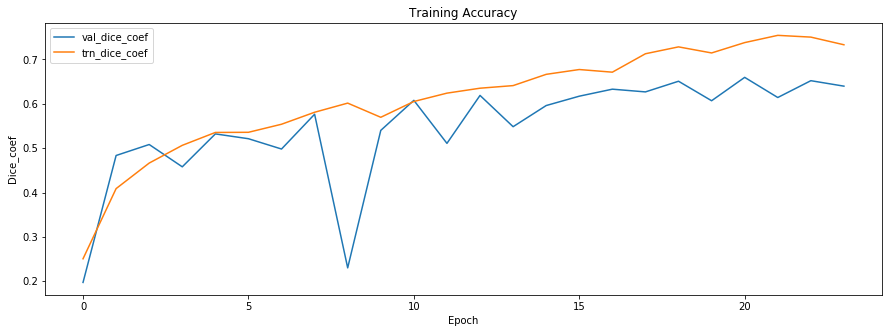

In [18]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

# Prediction EDA
In the images below (which all contain defects), we will display one prediction mask for a defect that is present. Note that `matplotlib` scales the mask's largest pixel value to yellow and smallest to blue. Therefore the presense of yellow doesn't indicate that the mask achieved a pixel value 1.0. The maximum pixel value is indicated in the titles and is a measure of mask confidence.

In [19]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS)
val_set = train2.iloc[idx:];
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)],preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

2/2 [==============================] - 4s 2s/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


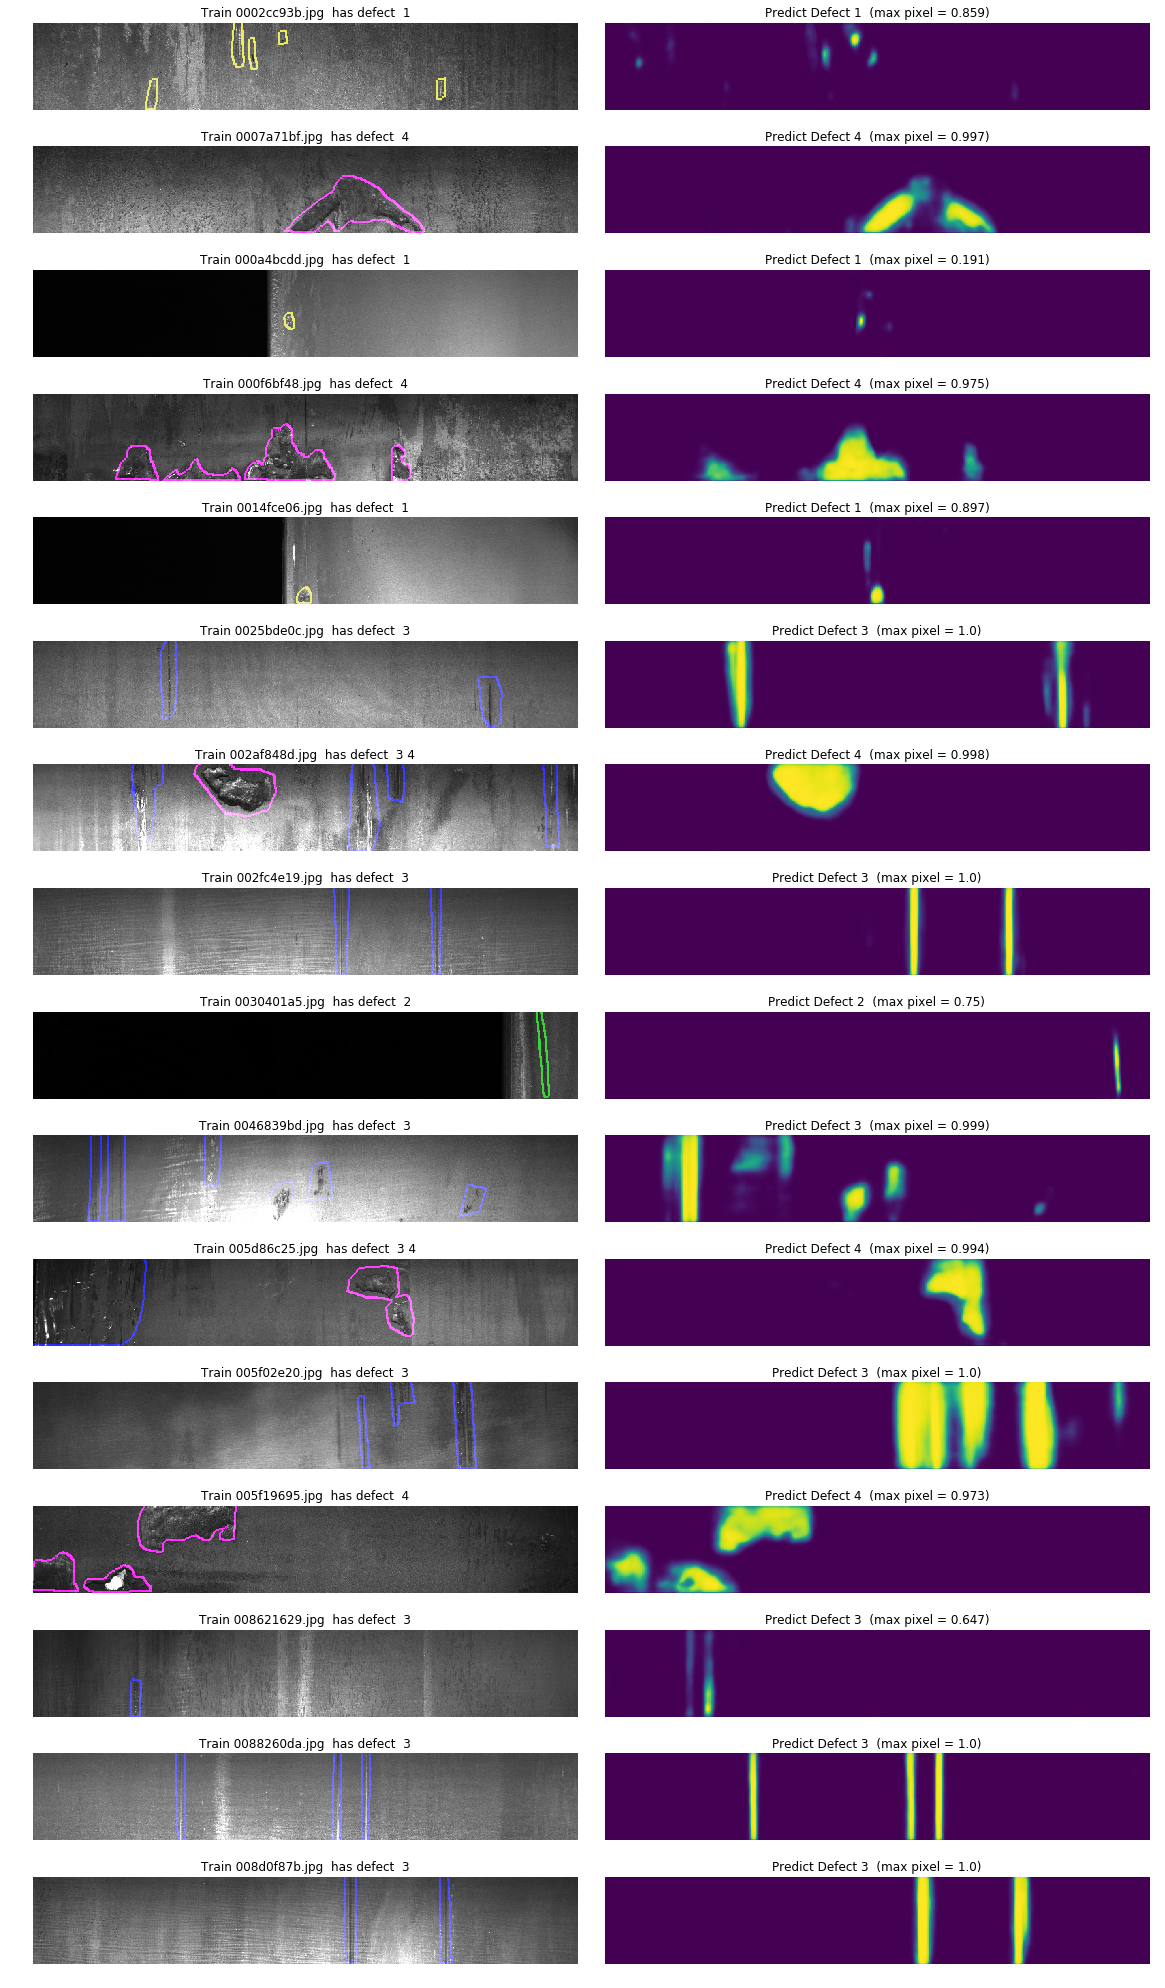

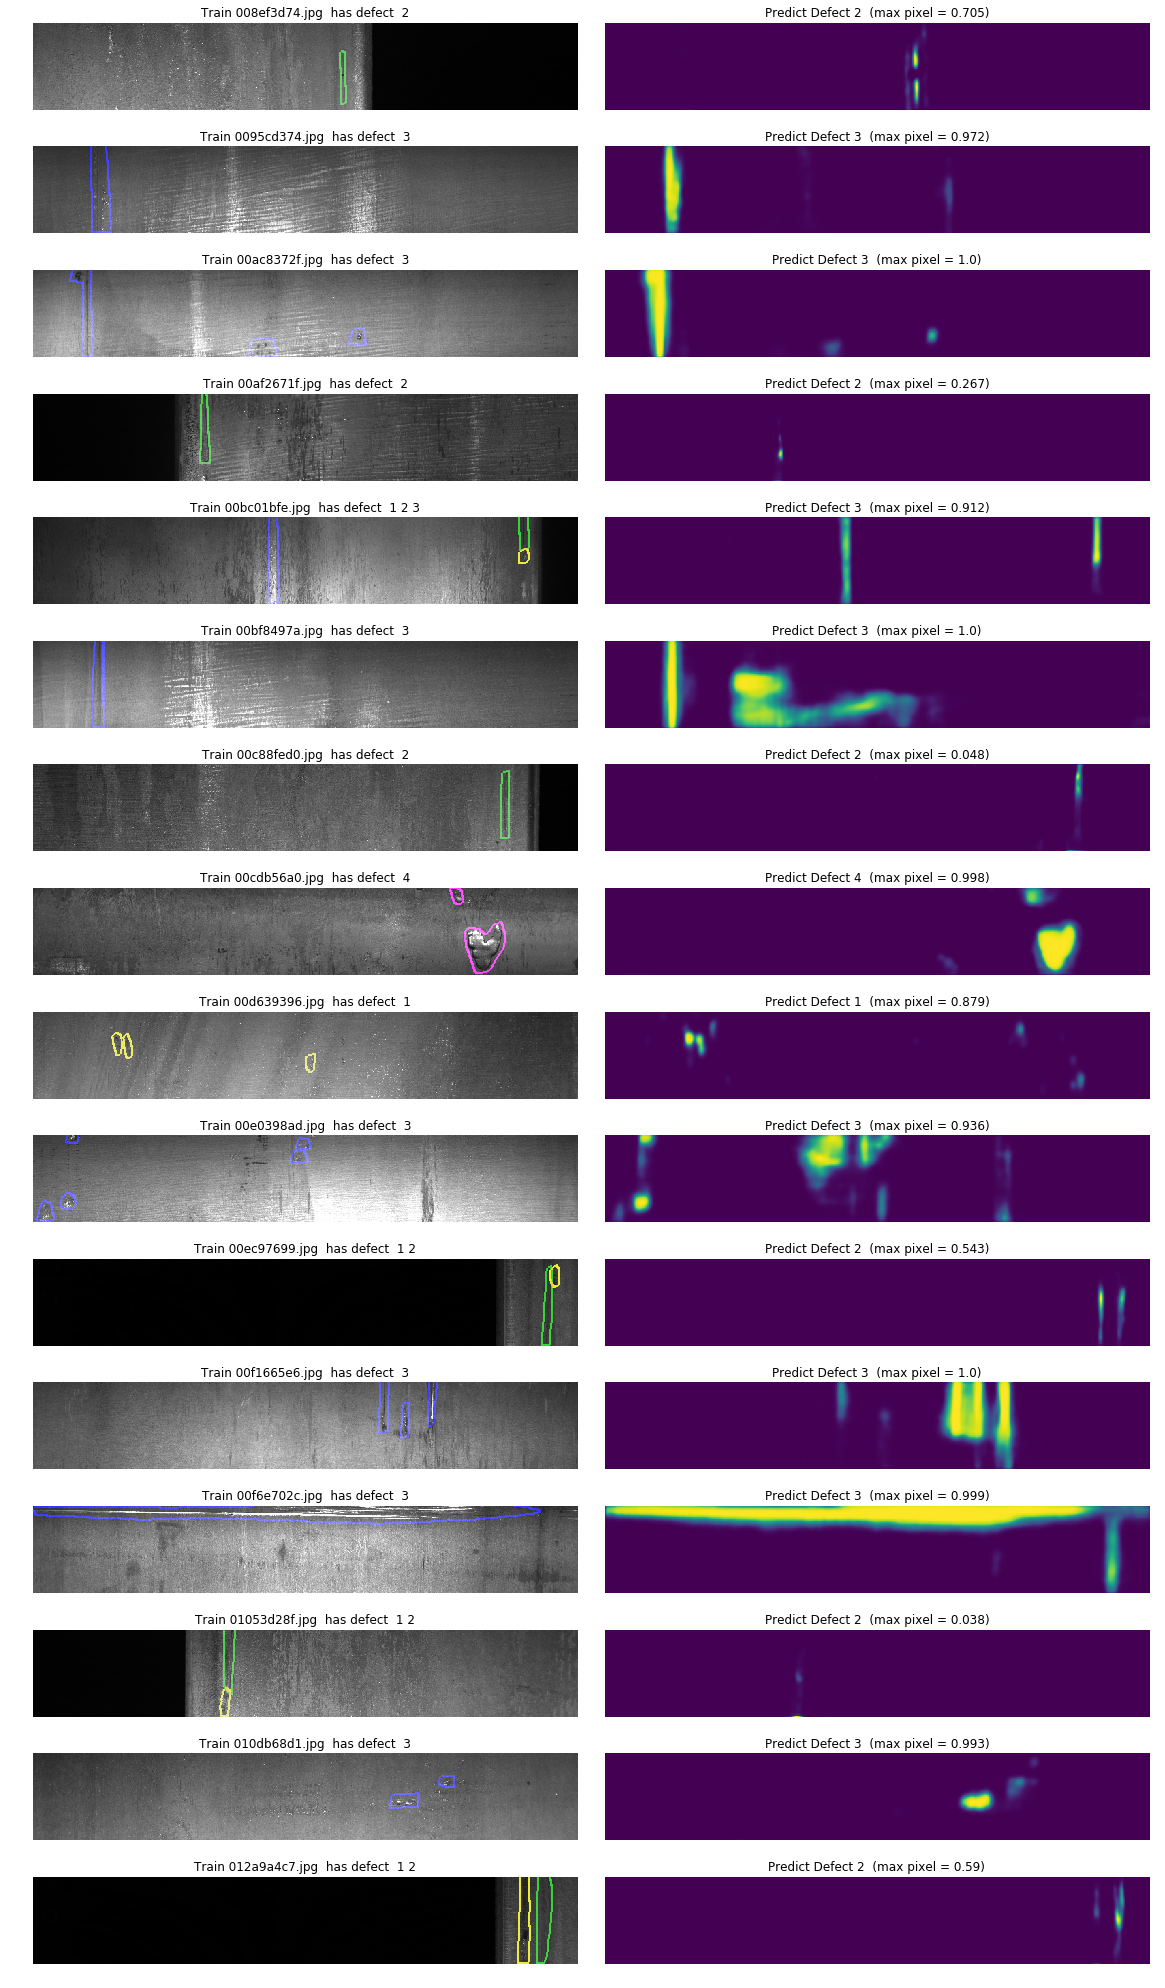

In [20]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Error EDA 1
The masks above look pretty good. But note that we are only plotting masks corresponding to defects that are present. Below, regardless of what type of defect an image has, we will plot the defect 3 mask. Only the blue contour lines on the left are defect 3. So when we see contours on the left that do not include blue, we should not see defect 3 masks but we still do.

In [21]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS 1, 2, 4)
val_set = train2.iloc[idx:]
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches = DataGenerator(val_set2,preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

1/1 [==============================] - 0s 248ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


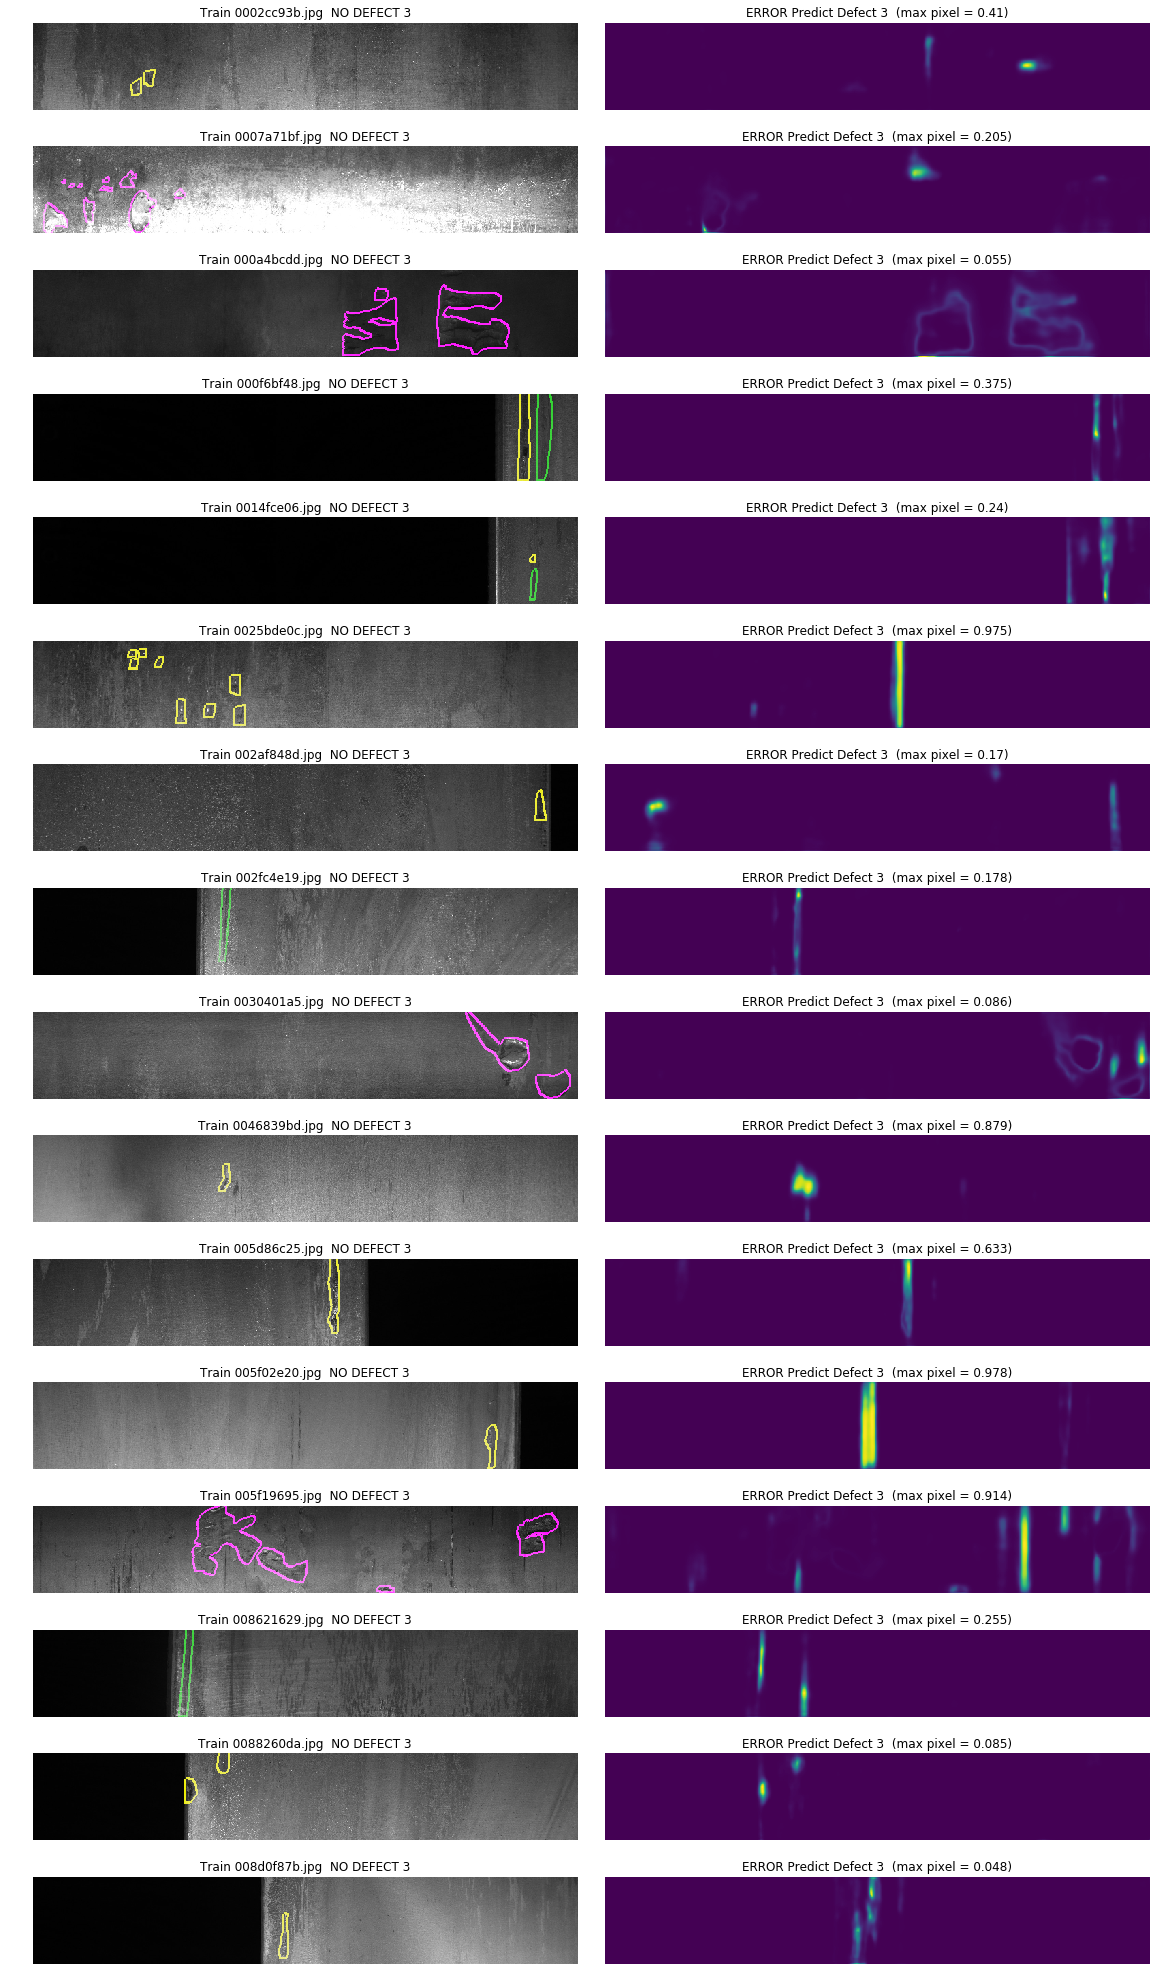

In [22]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        three = False
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0): 
                three=np.sum(msk)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra = ''; extra2 = ''
        if not three: 
            extra = 'NO DEFECT 3'
            extra2 = 'ERROR '
        plt.title('Train '+train2.iloc[16*i+k,0]+'  '+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        dft=3
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title(extra2+'Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Error EDA 2
We will plot histograms showing the predicted size of each defect mask. We would hope that if an image does not have a particular defect then UNET would not predict a mask (i.e. predict less than 250 pixel mask). This is not the case. When UNET predicts a mask when a defect isn't present, we call that an "incorrect" mask. When UNET predicts a mask when a defect is present, we call that a "correct" mask. If UNET predicts less than 250 pixels, we will treat that as no mask predicted. Let's compare the distribution of "incorrect" versus "correct" masks for each defect type.

UNET outputs masks using all floating point values between 0 and 1 inclusive. When we submit to Kaggle, we need to use only integer 0 and 1. Therefore we must convert mask floating points into integers using a threshold. If `pixel>=THRESHOLD` then `pixel=1` else `pixel=0`. We will plot histograms for various thresholds below. We will consider all masks with less than 250 pixels as empty masks (where `pixel_count = 4 * pixel count` on 128x800).

From the plots below, we see that UNET doesn't create more and/or larger masks for images with defects. UNET seems to equally create masks for all images whether there is a defect or not. If we submit the output from UNET to Kaggle, our LB score will be lower than submitting all empty masks (LB 0.85674) because there are more mistake masks than correct masks. Each mistake decreases our LB score by `1/7200` and each correct increases our score by `c*(1/7200)` where `0<=c<=1` is our average dice score.

In [23]:
# PREDICT FROM VALIDATION SET (USE ALL)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

83/83 [==============================] - 18s 212ms/step


######################################
## Threshold = 0.1 displayed below ##
######################################


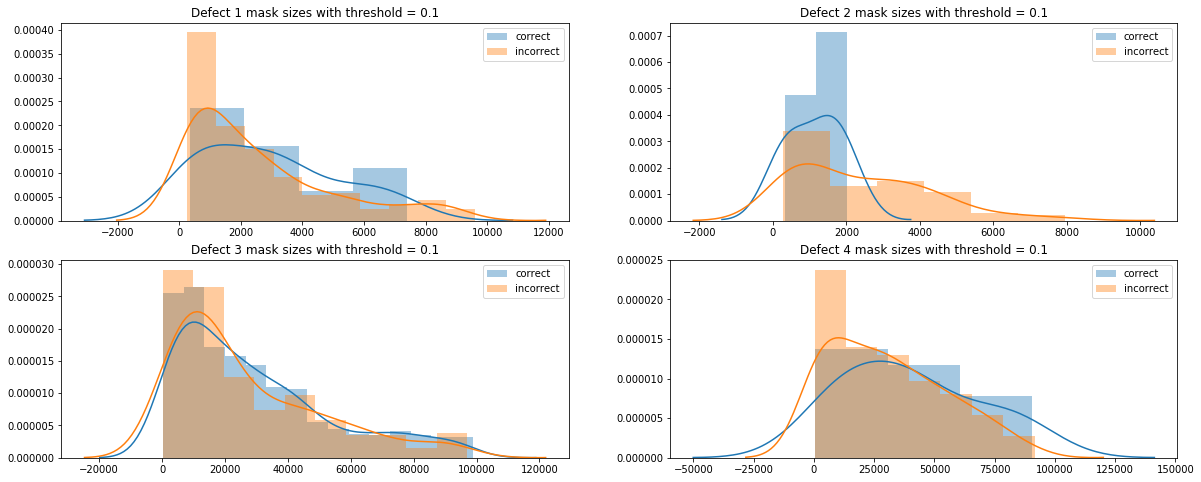

With threshold = 0.1 , defect 1 has 40 correct and 244 incorrect masks
With threshold = 0.1 , defect 2 has 5 correct and 78 incorrect masks
With threshold = 0.1 , defect 3 has 911 correct and 296 incorrect masks
With threshold = 0.1 , defect 4 has 18 correct and 151 incorrect masks

######################################
## Threshold = 0.25 displayed below ##
######################################


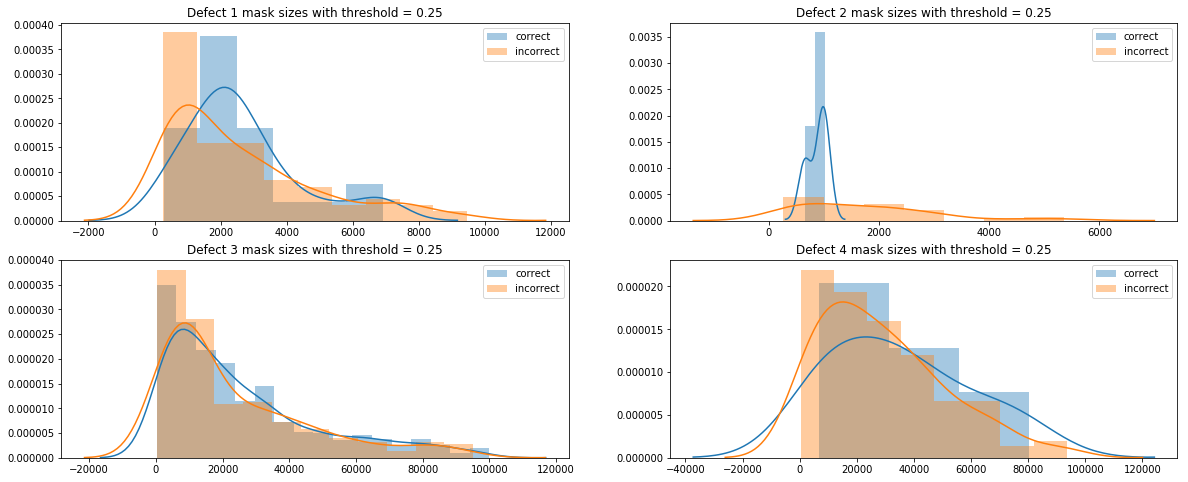

With threshold = 0.25 , defect 1 has 26 correct and 163 incorrect masks
With threshold = 0.25 , defect 2 has 3 correct and 55 incorrect masks
With threshold = 0.25 , defect 3 has 873 correct and 279 incorrect masks
With threshold = 0.25 , defect 4 has 17 correct and 134 incorrect masks

######################################
## Threshold = 0.5 displayed below ##
######################################


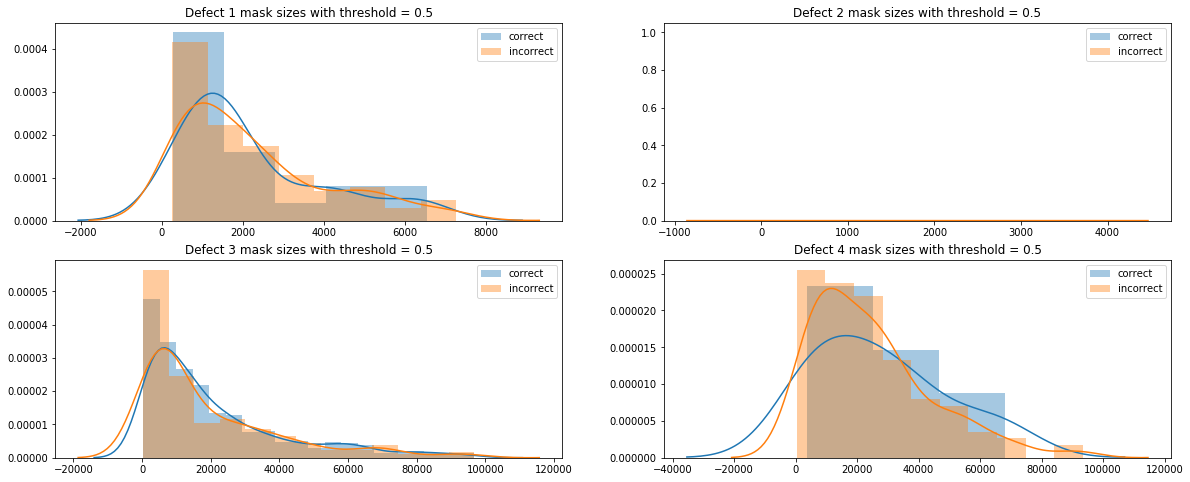

With threshold = 0.5 , defect 1 has 20 correct and 119 incorrect masks
With threshold = 0.5 , defect 2 has 1 correct and 30 incorrect masks
With threshold = 0.5 , defect 3 has 834 correct and 263 incorrect masks
With threshold = 0.5 , defect 4 has 17 correct and 125 incorrect masks

######################################
## Threshold = 0.75 displayed below ##
######################################


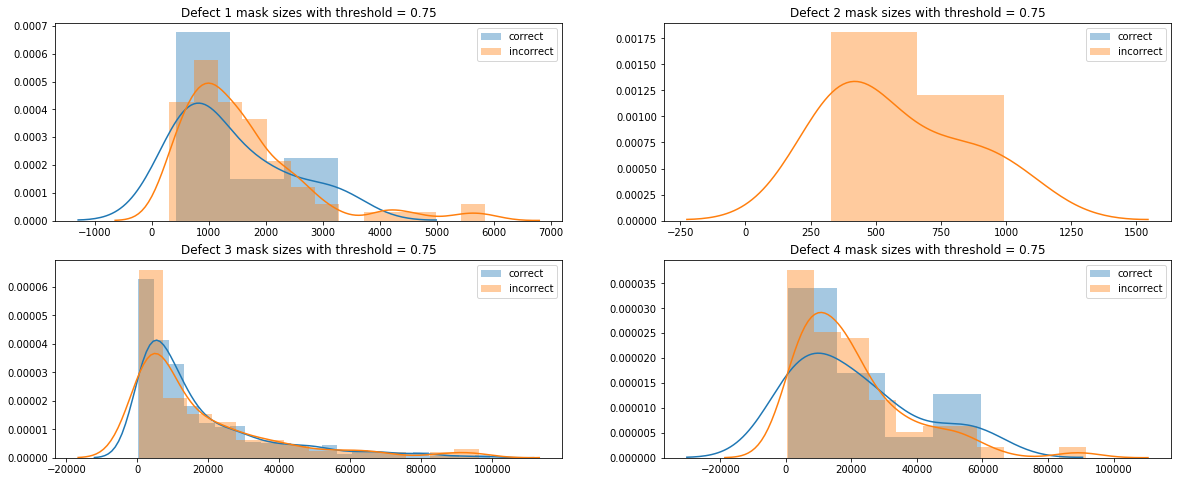

With threshold = 0.75 , defect 1 has 14 correct and 77 incorrect masks
With threshold = 0.75 , defect 2 has 0 correct and 5 incorrect masks
With threshold = 0.75 , defect 3 has 782 correct and 239 incorrect masks
With threshold = 0.75 , defect 4 has 17 correct and 117 incorrect masks

######################################
## Threshold = 0.9 displayed below ##
######################################


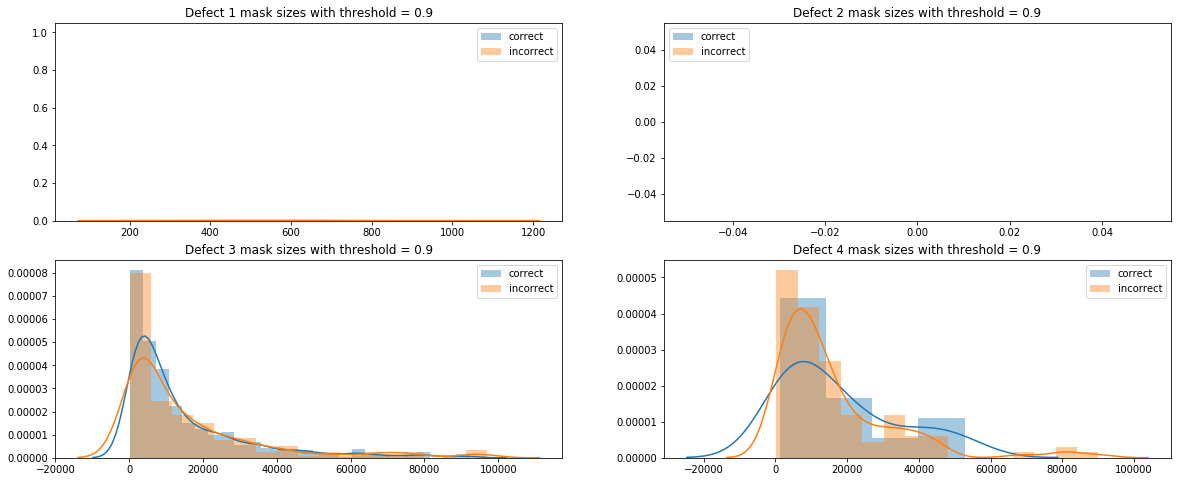

With threshold = 0.9 , defect 1 has 1 correct and 6 incorrect masks
With threshold = 0.9 , defect 2 has 0 correct and 0 incorrect masks
With threshold = 0.9 , defect 3 has 708 correct and 213 incorrect masks
With threshold = 0.9 , defect 4 has 15 correct and 112 incorrect masks



In [24]:
# PLOT RESULTS
import seaborn as sns
pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('######################################')
    print('## Threshold =',THRESHOLD,'displayed below ##')
    print('######################################')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[i,j+1]=='': incorrect[j].append(4*sums[j])
            else: correct[j].append(4*sums[j])
    plt.figure(figsize=(20,8))
    for j in range(4):
        limit = [10000,10000,100000,100000][j]
        plt.subplot(2,2,j+1)
        sns.distplot([x for x in correct[j] if x<limit], label = 'correct')
        sns.distplot([x for x in incorrect[j] if x<limit], label = 'incorrect')
        plt.title('Defect '+str(j+1)+' mask sizes with threshold = '+str(THRESHOLD)); plt.legend()
    plt.show()
    for j in range(4):
        c1 = np.array(correct[j])
        c2 = np.array(incorrect[j])
        print('With threshold =',THRESHOLD,', defect',j+1,'has',len(c1[c1!=0]),'correct and',len(c2[c2!=0]),'incorrect masks')
    print()

# Submit to Kaggle

In [ ]:
# SAVE MODEL
model.save('UNET.h5')

# LOAD MODEL
# from keras.models import load_model
# model = load_model('UNET.h5',custom_objects={'dice_coef':dice_coef})
